##1: Setting the Environment

In [11]:
#@title 1.1: Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
#@title 1.2: Setting a folder as working directory
%cd /content/drive/My Drive/Sentiment Analysis Using LSTM
!ls

/content/drive/My Drive/Sentiment Analysis Using LSTM
depression_dataset_reddit_cleaned.csv	  glove.6B.100d.txt
depression_dataset_reddit_normalized.csv  reddit_sampled_testing.csv


In [13]:
#@title 1.3: Importing libraries and functions

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

from keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPool1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

#For 2.4 Distribution of upvote ratio and score
import seaborn as sns

##2: Loading The Dataset

In [14]:
#@title 2.1: Importing the Reddit Comments Dataset
reddit_comments = pd.read_csv("depression_dataset_reddit_cleaned.csv")

In [15]:
#@title 2.2: Dataset Exploration

print("Reddit Dataset Shape: " + str(reddit_comments.shape))

print("Reddit Dataset Heading")
reddit_comments.head(5)

Reddit Dataset Shape: (7731, 2)
Reddit Dataset Heading


clean_text  is_depression
0  we understand that most people who reply immed...              1
1  welcome to r depression s check in post a plac...              1
2  anyone else instead of sleeping more when depr...              1
3  i ve kind of stuffed around a lot in my life d...              1
4  sleep is my greatest and most comforting escap...              1

In [16]:
#@title 2.3: Checking for slicing values

reddit_comments.isnull().values.any()

False

In the first Iteration, there were null values. To check for and remove null (or missing) values from a DataFrame in Python, particularly if you're using pandas, you can follow these steps:

1. **Check for Null Values**:
   ```python
   reddit_comments.isnull().values.any()
   ```
   This line of code checks if there are any null values in the DataFrame `reddit_comments`. If it returns `True`, it means there are null values present in the DataFrame; otherwise, it returns `False`.

2. **Remove Null Values**:
   You have a few options to handle null values. You can either drop rows containing null values or fill them with appropriate values based on your use case.

   - To remove rows with null values, you can use the `dropna()` method:
     ```python
     reddit_comments.dropna(inplace=True)
     ```

   - Alternatively, you can fill null values with specific values using the `fillna()` method:
     ```python
     # Fill null values with a specific value, for example, 0
     reddit_comments.fillna(0, inplace=True)
     ```

   - Another option is to interpolate the null values with nearby values:
     ```python
     reddit_comments.interpolate(inplace=True)
     ```

   Choose the appropriate method based on your data and analysis requirements. `inplace=True` ensures that the changes are made directly to the original DataFrame.

3. **Verify Removal**:
   After performing the removal or filling operation, you can recheck if any null values remain in the DataFrame:
   ```python
   reddit_comments.isnull().values.any()
   ```
   If it returns `False`, it means you have successfully handled the null values.

Remember to handle null values based on the specific requirements and characteristics of your dataset. Depending on your analysis, dropping null values may lead to data loss, so it's essential to consider alternative strategies such as imputation or interpolation when appropriate.

I chose :
```python     
reddit_comments.dropna(inplace=True)
```

In [ ]:
#@title 2.3.1: Dropping Null values if 2.3 returns True
reddit_comments.dropna(inplace=True)

<Axes: xlabel='is_depression', ylabel='count'>

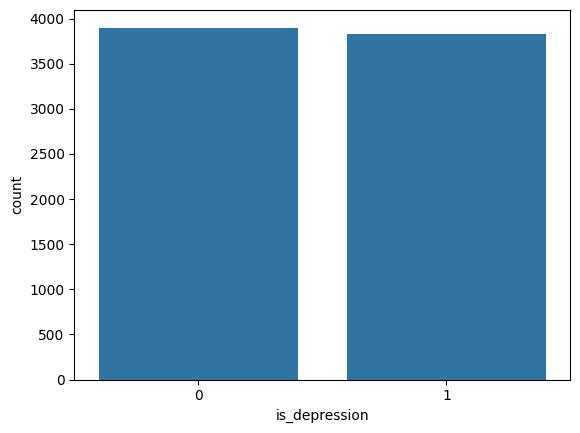

In [17]:
#@title 2.4.1 Distribution of upvote ratio

sns.countplot(x='is_depression', data = reddit_comments)

<Axes: xlabel='is_depression', ylabel='count'>

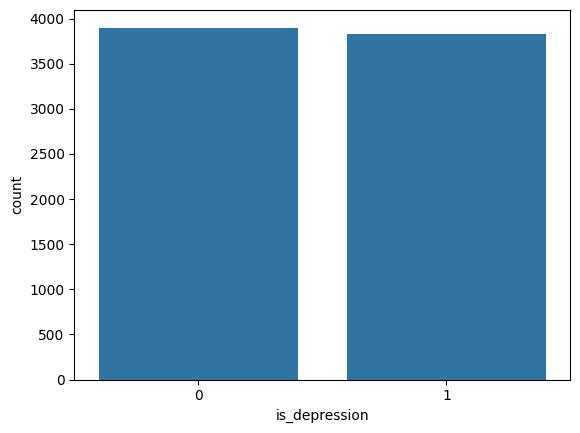

In [9]:
#@title 2.4.2 Distribution of score ratio
sns.countplot(x='is_depression', data = reddit_comments)

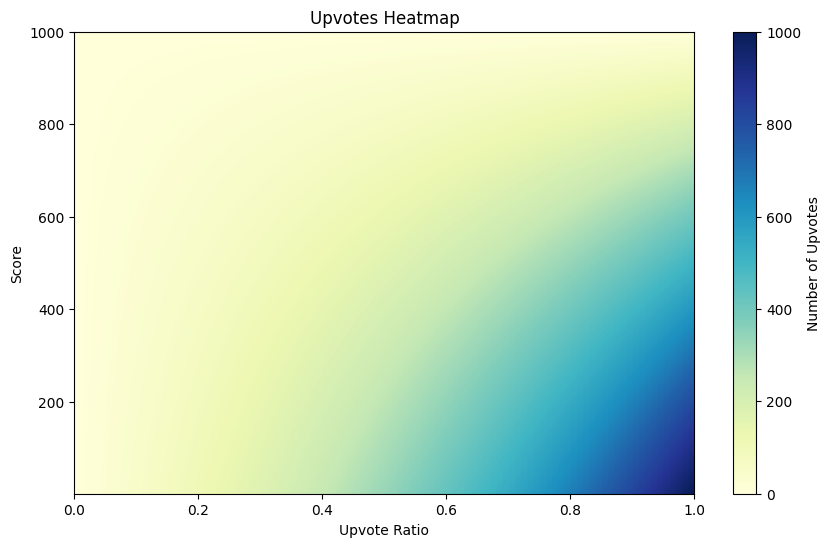

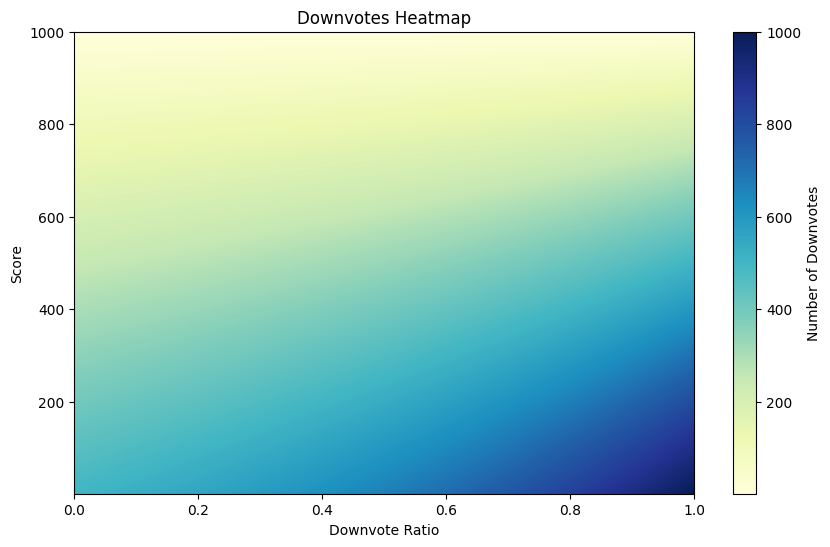

In [ ]:
#@title 2.4.3: Upvotes and downvotes heatmap

import numpy as np
import matplotlib.pyplot as plt

def calculate_votes(upvote_ratio, score):
    upvotes = (upvote_ratio * score) / (2 - upvote_ratio)
    downvotes = score / (2 - upvote_ratio)
    return upvotes, downvotes

# Generate data for heatmap
upvote_ratios = np.linspace(0, 1, 100)
scores = np.arange(1, 1001)
upvotes_grid, downvotes_grid = np.meshgrid(upvote_ratios, scores)
upvotes, downvotes = calculate_votes(upvotes_grid, downvotes_grid)

# Plot heatmap with squares
plt.figure(figsize=(10, 6))
plt.imshow(upvotes, cmap='YlGnBu', aspect='auto', extent=[0, 1, 1, 1000])
plt.colorbar(label='Number of Upvotes')
plt.xlabel('Upvote Ratio')
plt.ylabel('Score')
plt.title('Upvotes Heatmap')
plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(downvotes, cmap='YlGnBu', aspect='auto', extent=[0, 1, 1, 1000])
plt.colorbar(label='Number of Downvotes')
plt.xlabel('Downvote Ratio')
plt.ylabel('Score')
plt.title('Downvotes Heatmap')
plt.show()


###Information: Reddit's Social Score system link:

https://www.reddit.com/r/modnews/comments/16is6dh/contributor_quality_score_available_to_all/?rdt=39338

There is no value set, so I would set this CQS value or score value threshold as 150

Mean Upvote Ratio: 0.9430486255779688
Mean Score: 150
12365
3555
3268
493


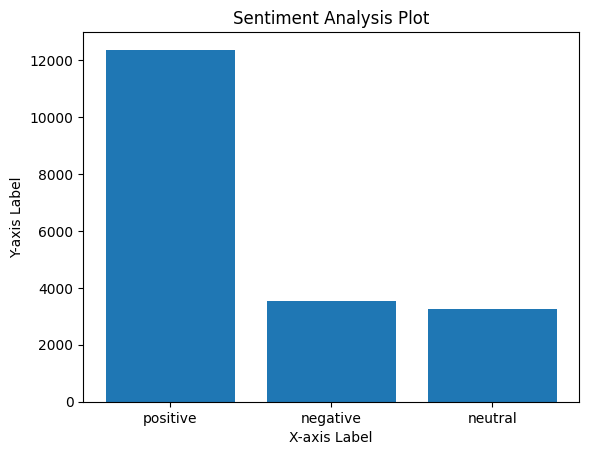

In [ ]:
#@title 2.4 Sentiment Sheet

import matplotlib.pyplot as plt

positive = 0
negative = 0
neutral = 0
exception = 0

set_of_positive_markings = []
set_of_negative_markings = []
set_of_neutral_markings = []
binary_sentiment_labels = []

# Calculate the mean of the 'upvote_ratio' column
mean_upvote_ratio = reddit_comments['upvote_ratio'].mean()
threshold_score = 150

print("Mean Upvote Ratio: " + str(mean_upvote_ratio))
print("Mean Score: " + str(threshold_score))

# Iterate through the DataFrame
for index, row in reddit_comments.iterrows():
    # Access the 'upvote_ratio' column for each row
    u_ratio = row['upvote_ratio']
    scr = row['score']
    tkn = row['comment_tokens']

    # Check conditions and update counters
    if u_ratio > mean_upvote_ratio and scr > threshold_score:
        positive += 1
        set_of_positive_markings.append("positive")
        set_of_negative_markings.append(0)
        set_of_neutral_markings.append(0)
        binary_sentiment_labels.append(1)
    elif u_ratio < 0.92 and scr > threshold_score:
        negative += 1
        set_of_positive_markings.append(0)
        set_of_negative_markings.append("negative")
        set_of_neutral_markings.append(0)
        binary_sentiment_labels.append(0)
    elif u_ratio <= mean_upvote_ratio and u_ratio >= 0.92:
        neutral += 1
        set_of_positive_markings.append(0)
        set_of_negative_markings.append(0)
        set_of_neutral_markings.append("neutral")
        binary_sentiment_labels.append(0)
    else:
        exception += 1
        binary_sentiment_labels.append(0)

print(int(positive))
print(int(negative))
print(int(neutral))
print(int(exception))

# Data
x_values = []
y_values = []

# Append negative value
x_values.append('positive')
y_values.append(int(positive))

# Append negative value
x_values.append('negative')
y_values.append(int(negative))

# Append neutral value
x_values.append('neutral')
y_values.append(int(neutral))

# Plotting
plt.bar(x_values, y_values)

# Adding labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Sentiment Analysis Plot')

# Display the plot
plt.show()

## 3: Data Preprocessing

In [ ]:
#@title 3.1.1: Analyse comments for preprocessing

reddit_comments["comment"][5]

"that's good you, maybe waste much time it. work required substantial rewrite anyway whole new experimental setup, many flaws point disappear next version anyway. big picture comments much valuable. already good papers get improved nitpicking careful reading analysis. otherwise, wasting life trying shine someone else's turd."

There is not much to preprocess, so we can remove stopwords through nltk, punctuations and numbers, single characters and multiple spaces

In [ ]:
#@title 3.1.2: Download Stopwords from nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
#@title 3.1.3: Preprocess the comments data

def preprocess_text(sen):
  sentence = sen.lower()

  #remove punctuations and numbers

  sentence = re.sub('[^a-zA-Z]', ' ', sentence)

  #remove single characters
  sentence = re.sub(r"\s+[a-zA-Z]\s", ' ',sentence)

  #remove multiple spaces
  sentence = re.sub(r'\s+', ' ',sentence)

  #remove stopwords
  pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
  sentence = pattern.sub('', sentence)

  return sentence


In [ ]:
#@title 3.1.4: Calling preprocess_text function on movie_reviews

preprocessed_comments = []
sentences = reddit_comments['comment']
for sen in sentences:
  preprocessed_comments.append(preprocess_text(sen))

In [ ]:
#@title 3.1.5: Sample Cleaned Up Comments

print(preprocessed_comments[5])

good maybe waste much time work required substantial rewrite anyway whole new experimental setup many flaws point disappear next version anyway big picture comments much valuable already good papers get improved nitpicking careful reading analysis otherwise wasting life trying shine someone else turd 


In [ ]:
#@title 3.2 Splitting Dataset into 80-20 dataset

X_train, X_test, y_train, y_test = train_test_split(preprocessed_comments, binary_sentiment_labels, test_size=0.20, random_state=42)

##4: Preparing Embedded Layer

In [ ]:
#@title 4.1: Embedding Layer words in numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [ ]:
#@title 4.2: Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

24852

In [ ]:
#@title 4.3: Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
#@title 4.4: Load GloVe word embeddings and create as Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
  records=line.split()
  word = records[0]
  vector_dimensions = asarray(records[1:], dtype='float32')
  embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
#@title 4.5: Embedding Matrix with 100 columns

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
  embedding_vector = embeddings_dictionary.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

In [ ]:
#@title 4.6: Output
embedding_matrix.shape

(24852, 100)

##5: Model Training

###5.1: Simple Neural Network

In [ ]:
#@title 5.3.1: Recurrent Neural Network (LSTM)

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable = False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [ ]:
#@title 5.3.2: Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          2485200   
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,602,577
Trainable params: 117,377
Non-trainable params: 2,485,200
_________________________________________________________________
None


In [ ]:
#@title: 5.3.3 Model Training

import numpy as np
X_train = np.array(X_train)
y_train = np.array(y_train)

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
99/99 [==============================] - 41s 384ms/step - loss: 0.6667 - acc: 0.6224 - val_loss: 0.6638 - val_acc: 0.6199
Epoch 2/6
99/99 [==============================] - 36s 367ms/step - loss: 0.6602 - acc: 0.6268 - val_loss: 0.6649 - val_acc: 0.6186
Epoch 3/6
99/99 [==============================] - 39s 389ms/step - loss: 0.6579 - acc: 0.6298 - val_loss: 0.6651 - val_acc: 0.6173
Epoch 4/6
99/99 [==============================] - 38s 388ms/step - loss: 0.6563 - acc: 0.6308 - val_loss: 0.6657 - val_acc: 0.6167
Epoch 5/6
99/99 [==============================] - 37s 378ms/step - loss: 0.6543 - acc: 0.6328 - val_loss: 0.6663 - val_acc: 0.6167
Epoch 6/6
99/99 [==============================] - 37s 374ms/step - loss: 0.6530 - acc: 0.6333 - val_loss: 0.6670 - val_acc: 0.6145


In [ ]:
#@title 5.3.4: Predictions on the Test Set

import numpy as np

# Convert X_test and y_test to NumPy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

score = lstm_model.evaluate(X_test, y_test, verbose=1)

124/124 [==============================] - 9s 74ms/step - loss: 0.6576 - acc: 0.6368


In [ ]:
#@title 5.3.5: Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.6576493382453918
Test Accuracy: 0.636779248714447
